# pythonを使用してファイナンス理論を実装しよう②

## 前回のおさらい（一言でいうと） ※あくまでファイナンスにおける
- 単純利益率 ： 元本に対して得られる利益率（短い期間の単体株価に有効）
- 対数利益率 ： 元本に対する利益の対数の差を表す指標（長期期間の単体・複数株価に有効）
- マーケットインデックス ： 経済や株式市場全体の動向を反映する指数
- リスク（分散可能） ： 標準偏差（ボラティリティ）
- 分散・共分散・相関係数 ： 関係性とボラティリティを表す指標
- 効率的フロンティア ： リスクが同じでも、最適な利益を生むためのポートフォリオ（保有割合）の組み合わせがあるという概念

In [1]:
# 必要ライブラリのインポート
import numpy as np
import pandas as pd
import yfinance as yf
import japanize_matplotlib

## ベータを求めよう。
- ベータ：日経平均（マーケット）の動きを1とした時、トヨタの株はどれだけ上下にぶれるか
- 注：本来であれば日本マーケットはTOPIXを使用すべきであるが、現在yfinanceで取得不可のため日経平均を使用している。

In [2]:
#1-1 銘柄の検索
stock_code = pd.read_csv('stock_codes.csv')
search = 'トヨタ'
stock_code[stock_code['銘柄名'].str.contains(search)]

,コード,銘柄名
911,3116,トヨタ紡織
2977,7203,トヨタ自動車


In [3]:
# 1-1 2010年1月1日〜2022年12月31日の「3116：トヨタ」と「^N225:日経平均」の株価をデータフレームとして取得しましょう
# トヨタ、 日経平均
start = '2010-01-01'
end = '2022-12-31'
tickers = {'トヨタ':'3116.T', '日経平均':'^N225'}

df = pd.DataFrame()
for ticker, number in tickers.items():
    df[ticker] = yf.download(number, start, end)['Adj Close']

df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,トヨタ,日経平均
Date,,
2010-01-04,1562.533936,10654.790039
2010-01-05,1554.092041,10681.830078
2010-01-06,1522.626831,10731.450195
2010-01-07,1456.625732,10681.660156
2010-01-08,1506.510132,10798.320312


In [4]:
#1-2 次に、データフレームの情報を株価から対数利益率に変換させましょう。
df_log = np.log(df / df.shift(1))
df_log

,トヨタ,日経平均
Date,,
2010-01-04,NaN,NaN
2010-01-05,-0.005417,0.002535
2010-01-06,-0.020454,0.004635
2010-01-07,-0.044314,-0.004650
2010-01-08,0.033673,0.010862
...,...,...
2022-12-26,0.016037,0.006482
2022-12-27,-0.001706,0.001589
2022-12-28,0.004543,-0.004068


In [5]:
#1-3 次に、トヨタと日経平均の共分散行列(年:246営業日とする)を作成しましょう。
# 年間の営業日を246日とする
df_cov = df_log.cov() * 246
df_cov

,トヨタ,日経平均
トヨタ,0.11286,0.043770
日経平均,0.04377,0.042932


In [6]:
#1-3 トヨタと日経平均の共分散を取得
toyota_cov_market = df_cov.iloc[0, 1] # df_cov.iloc[1, 0]でもOK
toyota_cov_market

0.04376982445268019

In [7]:
#1-3 日経平均の分散を取得
market_var = df_cov.iloc[1, 1] # df_log["日経平均"].var() * 246でもOK
market_var

0.042932048247914655

$$ \beta = \frac{\mathrm{Cov}(R_i, R_m)}{\mathrm{Var}(R_m)} $$

In [8]:
# 1-4 トヨタのベータ（年）値を算出しましょう
toyota_beta = toyota_cov_market / market_var
toyota_beta

1.0195140050138705

1以上なので、トヨタは日経平均（マーケット）よりも、動きが活発になるのがわかる。(0 ~ ディフェンシブ(lowrisk-lowreturn) ~ 1 ~ アグレッシブ(highrisk-highreturn) ~ 2)

## CAPM（資本資産評価モデル）に基づき、期待利益率を求める

- リスクフリーは一般的に10年国債が利用される。
- 債権サイト
https://www.bloomberg.co.jp/markets/rates-bonds/government-bonds/us

$$R_i = R_f + \beta_i \times (R_m - R_f)$$

In [9]:
# 1-5 次に、capm理論に伴うトヨタの期待利益率を算出
# リスクフリーレート：日本国債10年利回り：0.50%
# マーケット期待利益率：4.5%
toyota_capm = 0.005 + toyota_beta * (0.045 - 0.005)
toyota_capm

0.045780560200554814

## シャープレシオ

$$　\text{Sharpe Ratio}=\frac{\bar{R}_p-R_f}{\sigma_p}　$$

取ったリスクに対して、どの株が一番利益が出るのかを確認する

In [10]:
# 1-6 次に、トヨタのシャープレシオを求めましょう
shape_ratio = (toyota_capm - 0.005) / (df_log['トヨタ'].std() * 246 ** 0.5)
shape_ratio

0.12139007465592609

## シャープレシオまでを関数化し、いろいろな個別株のシャープレシオを比較してみよう！

In [11]:
# 1-7 株価取得からシャープレシオを求めるまでを関数化し、色々な銘柄のシャープレシオを比較してみましょう。 
def sharp_ratio(ticker, start, end, g_bonds, market_profit):
    """
    注：ticker（dict）には、1番目に個別株、2番目にマーケットとする。（この関数は2つ以上の銘柄を比較ができるように作られていない）
    """
            
    # データ読み込み
    df = pd.DataFrame()
    for ticker, number in tickers.items():
        df[ticker] = yf.download(number, start, end)['Adj Close']
        
    # 対数利益率を算出
    df_log = np.log(df / df.shift(1))
    # 共分散行列作成
    df_cov = df_log.cov() * 246
    # 個別とマーケットの共分散
    kobetu_cov_market = df_cov.iloc[0, 1]
    # マーケットの分散
    market_var = df_cov.iloc[1, 1]
    # ベータ
    beta = kobetu_cov_market / market_var
    # 期待利益率
    capm = g_bonds + beta * (market_profit - g_bonds)
    # シャープレシオ
    sharpe_ratio = (capm - g_bonds) / (df_log.iloc[:, 0].std() * 246 ** 0.5)
    
    return print(f"{df_log.columns[0]}のシャープレシオは{round(sharpe_ratio, 4)}です")

In [12]:
#1-7 ヤクルトのシャープレシオ
start = '2010-01-01'
end = '2022-12-31'
tickers = {'ヤクルト':'2267.T', '日経平均':'^N225'}
g_bonds = 0.005
market_profit= 0.045


sharp_ratio(ticker, start, end, g_bonds, market_profit)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ヤクルトのシャープレシオは0.0877です


In [13]:
#1-7 くら寿司のシャープレシオ
start = '2010-01-01'
end = '2022-12-31'
tickers = {'くら寿司':'2695.T', '日経平均':'^N225'}
g_bonds = 0.005
market_profit= 0.045


sharp_ratio(ticker, start, end, g_bonds, market_profit)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
くら寿司のシャープレシオは0.078です


In [14]:
# ソニーのシャープレシオ
start = '2010-01-01'
end = '2022-12-31'
tickers = {'ソニーグループ':'6758.T', '日経平均':'^N225'}
g_bonds = 0.005
market_profit= 0.045


sharp_ratio(ticker, start, end, g_bonds, market_profit)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ソニーグループのシャープレシオは0.1225です


上記の結果から、リスクに対して一番期待利益率が良いのはソニーと分かる！

---------------

参考:アルファとは<br>
$R_i = α + R_f + \beta_i \times (R_m - R_f)$
- 投資信託などがどれほどのパフォーマンスを発揮しているかを測る指標
- 基本的にCAPM（資本評価モデル）は、アルファ0を想定しているので、アルファが0以上ならばパフォーマンスが高いと言える

---------

## モンテカルロシミュレーション
- 過去のデータから将来の起こる確率を元にシミュレーションを作成する（シナリオ1、2、3・・・）
- 実際のビジネスにも多く使われている
- 過去の成長率と標準偏差は過去のデータを持っていることが前提となる
- S(t) = S(0)exp((μ - 0.5σ^2)t + σW(t))

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 将来の売上高

In [16]:
#2-1 企業Aの将来の売上高平均を過去のデータから1,000通りシミュレーションし、シミュレーション結果の平均値、最小値、最大値を算出しましょう。

# 過去の売上高平均（年）
rev_m = 100
# 標準偏差
reb_std = 20
# 回す回数
iterations = 1000

# 過去のデータから、将来の売上高を1,000通り取得する。（正規分布に従うと仮定する）
revenue = np.random.normal(rev_m, reb_std, iterations)
# 平均、最小値、最大値を取得
rev_mean = revenue.mean()
rev_min = revenue.min()
rev_max = revenue.max()

print(rev_mean)
print(rev_min)
print(rev_max)

99.93974848897733
38.446624776878984
151.43069712865673


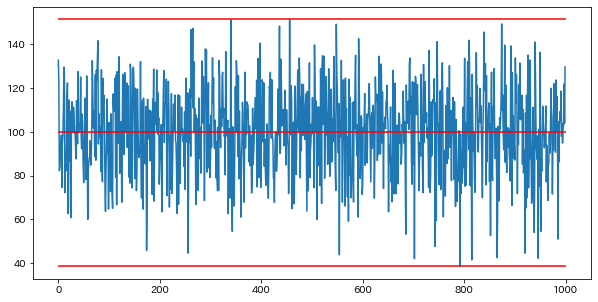

In [17]:
#2-2 次に、変数revenueの結果を折れ線グラフで可視化しましょう
plt.figure(figsize=(10, 5))

plt.plot(revenue)
plt.hlines(y=[rev_mean, rev_min, rev_max], xmin=0, xmax=1000, colors="r")

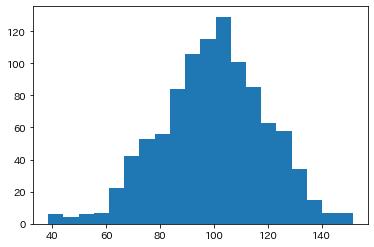

In [18]:
#2-3 次に、変数revenueの結果をヒストグラムで表示してみましょう。
plt.hist(revenue, bins=20)
plt.show()

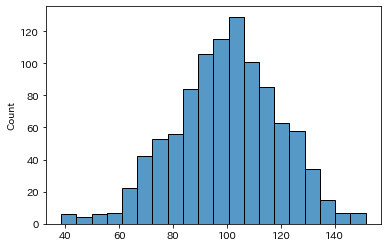

In [19]:
# 参考（seabornパターン）
sns.histplot(revenue, bins=20)
plt.show()

### 将来の売上原価

In [20]:
#2-4 将来の売上原価を1000通りシミュレーションし、平均値と標準偏差を算出しましょう。

# 売上原価：売上高の60%、標準偏差10
cogs = revenue * np.random.normal(0.6, 0.1)
# 売上原価
print(cogs.mean())
# 売上原価の標準偏差
print(cogs.std())

47.69977253235162
9.28129358968915


### 将来の売上総利益

In [21]:
#2-5 将来の売上総利益を1000通りシミュレーションし、平均値、標準偏差、最小値、最大値を算出しましょう。

gross_profit = revenue - cogs
# 平均値
print(gross_profit.mean())
# 標準偏差
print(gross_profit.std())
# 最小利益だった場合
print(gross_profit.min())
# 最大利益だった場合
print(gross_profit.max())

52.239975956625706
10.164714174326523
20.09661605441289
79.15505188577293


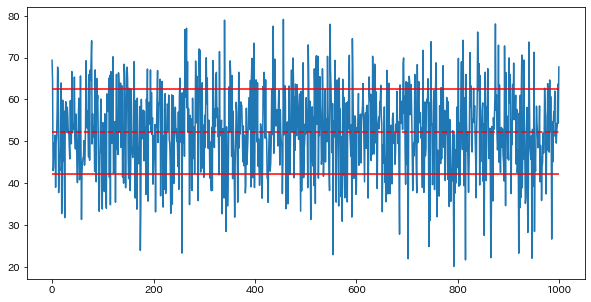

In [22]:
#2-6 1000通りの売上総利益の結果を折れ線グラフで表しましょう。また、平均値と標準偏差±1に横線を引く。

# 平均
mean = gross_profit.mean()
# 1σ
std_1plus = gross_profit.mean() + gross_profit.std()
# -1σ
std_1minus = gross_profit.mean() - gross_profit.std()

#　グラフ化
plt.figure(figsize=(10, 5))
plt.plot(gross_profit)
plt.hlines(y=[mean, std_1minus, std_1plus], xmin=0, xmax=1000, colors="r", linestyle=["dashed", "solid", "solid"])

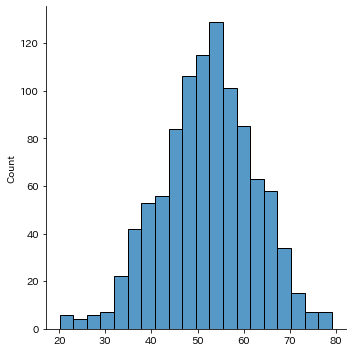

In [23]:
#2-7 ヒストグラムでも表示しましょう。 
sns.displot(gross_profit, bins=20)
plt.show()

上記の結果から、過去の傾向から将来の総利益は30億円前後になる確率が高いと言える。もしも50億円を超えてくるならサプライズ！？みたいな見方ができる。ただし、成長率やコンセンサス予想は加味されていないため、一概には言えない。

## ファイナンスにおけるモンテカルロシミュレーション

### 将来の株価を求めよう

In [24]:
# 必要なライブラいのインポート
from scipy import stats

In [25]:
#3-1 2010年1月1日〜2022年12月31日の「3116：トヨタ」の株価を取得しましょう。
start = '2010-01-01'
end = '2022-12-31'
tickers = {'トヨタ':'3116.T'}

df = pd.DataFrame()
for ticker, number in tickers.items():
    df[ticker] = yf.download(number, start, end)['Adj Close']

df.head()

[*********************100%***********************]  1 of 1 completed


,トヨタ
Date,
2010-01-04,1562.534424
2010-01-05,1554.092163
2010-01-06,1522.626587
2010-01-07,1456.625732
2010-01-08,1506.510254


In [26]:
#3-2 次に、データフレームの情報を、「株価」から「1日あたりの対数利益率の変化」を求めましょう。

# データの変化率を求める
toyota_log_profit = np.log(1 + df.pct_change())
toyota_log_profit.head()

,トヨタ
Date,
2010-01-04,NaN
2010-01-05,-0.005418
2010-01-06,-0.020455
2010-01-07,-0.044314
2010-01-08,0.033673


### ドリフト
$$\text{drift} = u - \frac{1}{2} \cdot \text{var}$$
- drift = u - 1/2*var

In [27]:
#3-3 ドリフトを求めましょう。
u = toyota_log_profit.mean()
var = toyota_log_profit.var()
drift = u - (0.5 * var)
drift

トヨタ   -0.000191
dtype: float64

### ボラティリティ
- 標準偏差のこと

In [28]:
#3-4 ボラティリティを求めましょう。
std = toyota_log_profit.std()
std

トヨタ    0.021419
dtype: float64

### ブラウン運動
- ブラウン運動モデル = exp((μ + σ * ε))

In [29]:
#3-5 次に、ブラウン運動モデルを算出しましょう。（難問）

n_interval = 1000 #将来1000日分予測するため
iterations = 10 #シナリオを10回分作成するか

# drift.values：型をpandasからarray型に変更
# std.values：型をpandasからarray型に変更
# np.random.rand(10, 1000):1000行10列の（0から1の値）をランダムに取得
# stats.norm.ppf():累積分布関数が指定した値を取得
# np.exp():指数関数
daily_returns =  np.exp(drift.values + std.values * stats.norm.ppf(np.random.rand(n_interval, iterations)))
daily_returns

array([[0.96549069, 1.0159202 , 0.98972833, ..., 0.99374635, 1.01835847,
        0.99451918],
       [0.98553776, 0.95707411, 1.01093291, ..., 0.98267557, 1.00678266,
        1.01158048],
       [1.00710975, 1.02557321, 1.02267283, ..., 0.99982117, 1.05883213,
        0.98094569],
       ...,
       [1.01726658, 1.01581212, 1.00464603, ..., 1.00627949, 1.01460201,
        0.99714936],
       [1.02422111, 0.98816199, 1.02546552, ..., 0.96709374, 0.96522617,
        1.02911155],
       [1.00830606, 1.00338042, 1.01768724, ..., 1.0139972 , 1.00570526,
        1.00359357]])

## モンテカルロシミュレーション

In [30]:
# dfの中身を確認
df.head()

,トヨタ
Date,
2010-01-04,1562.534424
2010-01-05,1554.092163
2010-01-06,1522.626587
2010-01-07,1456.625732
2010-01-08,1506.510254


In [31]:
#3-6 モンテカルロシミュレーションによる株価を予測しよう
# 最新の日株価取得
s0 = df.iloc[-1]
# 1000行10列の0が入った配列を作成
price_list = np.zeros_like(daily_returns)
# 初めの1行めに最新の日の株価を入れる。
price_list[0] = s0

# ブラウン運動で求めた行列と最新株価の行列を掛け合わせる。
for t in range(1, n_interval):
    price_list[t] = price_list[t - 1] * daily_returns[t]
price_list

array([[1766.        , 1766.        , 1766.        , ..., 1766.        ,
        1766.        , 1766.        ],
       [1740.45967908, 1690.19288023, 1785.30751187, ..., 1735.40506521,
        1777.97817197, 1786.45113128],
       [1752.83390523, 1733.41653993, 1825.78548528, ..., 1735.09471828,
        1882.58041779, 1752.4115352 ],
       ...,
       [2377.04561005, 1860.10548106, 2825.14651436, ...,  677.96856954,
        1086.23981647,  492.32228679],
       [2434.62028425, 1838.08552754, 2897.0903509 , ...,  655.65916244,
        1048.4671031 ,  506.65455182],
       [2454.84239495, 1844.29903421, 2948.33188146, ...,  664.8365516 ,
        1054.44887796,  508.47525139]])

In [32]:
# 参考：上記のコードは下記のようなことをしている。
print(f"for文1回目→将来シナリオ1：{price_list[0] * daily_returns[1]}")
print()
print(f"for文2回目→将来シナリオ2：{(price_list[0] * daily_returns[1]) * daily_returns[2]}")
print()
print(f"for文3回目→将来シナリオ3：{(price_list[0] * daily_returns[1] * daily_returns[2]) * daily_returns[3]}")
print()
print("将来1000営業日のシナリオが10出来上がる")

for文1回目→将来シナリオ1：[1740.45967908 1690.19288023 1785.30751187 1748.47778995 1782.71237934
 1772.95342136 1716.9917895  1735.40506521 1777.97817197 1786.45113128]

for文2回目→将来シナリオ2：[1752.83390523 1733.41653993 1825.78548528 1741.83121644 1819.09986291
 1761.1444887  1715.02385452 1735.09471828 1882.58041779 1752.4115352 ]

for文3回目→将来シナリオ3：[1798.78102904 1739.90356553 1791.24887552 1723.54646036 1877.95561453
 1744.83536879 1805.68200785 1759.77962055 1959.10455786 1782.44814115]

将来1000営業日のシナリオが10出来上がる


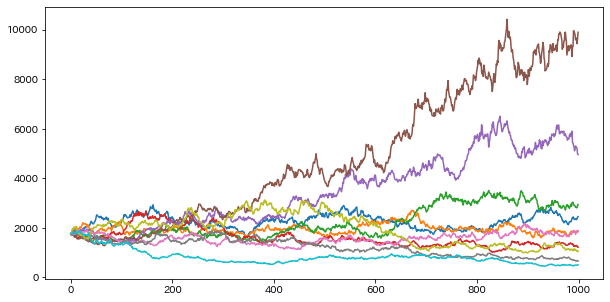

In [33]:
# 可視化
plt.figure(figsize=(10, 5))
plt.plot(price_list)
plt.show()

上記の図から、トヨタの将来株価は最新日よりも上がるシナリオが多いのか、下がるシナリオが多いのか、ボラティリティはどんなになるか。。。色々考察できる。

----------

参考：デリバティブ取引(ブラックショールズ方程式)にも活用が可能
- オプション（コールオプション（買い）、プットオプション（売り））
- フォワード
- フューチャー
- スワップ

-----

## 単回帰分析

In [34]:
# 4-1 「'diamonds'」（ダイヤモンドに関するデータセット）を取得する。
diamonds = sns.load_dataset("diamonds")
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


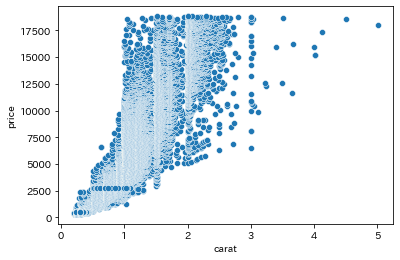

In [35]:
# 4-2:次に、diamondsデータセットからX軸に「'carat'」、y軸に「'price'」を指定し、完成イメージの通り散布図を作成しましょう。
X = diamonds["carat"]
y = diamonds["price"]

sns.scatterplot(X, y, data=diamonds)
plt.show()

In [36]:
# 必要ライブラリのインポート
import statsmodels.api as sm

In [37]:
#4-3: 「'carat'」（ダイヤの重さ）から「'price'」(ダイヤの価格）を予測するモデルを作成し、モデルのサマリー情報を確認
X1 = sm.add_constant(X)
reg = sm.OLS(y, X1).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 3.041e+05
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:17:40   Log-Likelihood:            -4.7273e+05
No. Observations:               53940   AIC:                         9.455e+05
Df Residuals:                   53938   BIC:                         9.455e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2256.3606     13.055   -172.830      0.0

上記から何が分かりますか？<br>
- R-squaredの数値：これは高いのか低いのか
- coefとは何なのか？
- F-statisticとは？
- P値とは？
- 少しばかり統計学の知識が必要となります。

## 多変量及び重回帰分析

In [38]:
# 説明変数を増やして、重回帰モデルを作成し、このモデルは良いモデルか確認しよう
y = diamonds["price"]
X = diamonds[["carat", "depth", "table", "x", "y", "z"]]

X1 = sm.add_constant(X)
reg = sm.OLS(y, X1).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 5.486e+04
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:17:40   Log-Likelihood:            -4.7090e+05
No. Observations:               53940   AIC:                         9.418e+05
Df Residuals:                   53933   BIC:                         9.419e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.085e+04    447.562     46.584      0.0

### 考察

サマリーから多重共線性が起こっている可能性がみてとれる。<br>
なぜか→下図のヒートマップではxとpriceの間は正の相関があるのに、xのcoef値がマイナスの値となっている。<br>
色々と考察してみよう。

<AxesSubplot:>

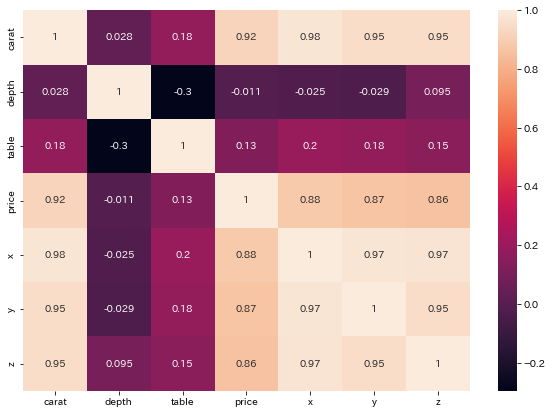

In [39]:
# 参考（相関係数）
plt.figure(figsize=(10, 7))
sns.heatmap(diamonds.corr(), annot=True)